In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions
import plotly.express as px
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import Ridge


In [ ]:
spark = SparkSession.builder.appName('premier_league').getOrCreate()

In [ ]:
df = spark.read.csv('/content/drive/MyDrive/Premier_league_players/dataset - 2020-09-24.csv', inferSchema=True, header=True)

Dataset tomado de:https://www.kaggle.com/datasets/rishikeshkanabar/premier-league-player-statistics-updated-daily/data

In [ ]:
df.show()

In [ ]:
df.dtypes

[('Name', 'string'),
 ('Jersey Number', 'int'),
 ('Club', 'string'),
 ('Position', 'string'),
 ('Nationality', 'string'),
 ('Age', 'int'),
 ('Appearances', 'int'),
 ('Wins', 'int'),
 ('Losses', 'int'),
 ('Goals', 'int'),
 ('Goals per match', 'double'),
 ('Headed goals', 'int'),
 ('Goals with right foot', 'int'),
 ('Goals with left foot', 'int'),
 ('Penalties scored', 'int'),
 ('Freekicks scored', 'int'),
 ('Shots', 'int'),
 ('Shots on target', 'int'),
 ('Shooting accuracy %', 'string'),
 ('Hit woodwork', 'int'),
 ('Big chances missed', 'int'),
 ('Clean sheets', 'int'),
 ('Goals conceded', 'int'),
 ('Tackles', 'int'),
 ('Tackle success %', 'string'),
 ('Last man tackles', 'int'),
 ('Blocked shots', 'int'),
 ('Interceptions', 'int'),
 ('Clearances', 'int'),
 ('Headed Clearance', 'int'),
 ('Clearances off line', 'int'),
 ('Recoveries', 'int'),
 ('Duels won', 'int'),
 ('Duels lost', 'int'),
 ('Successful 50/50s', 'int'),
 ('Aerial battles won', 'int'),
 ('Aerial battles lost', 'int'),
 ('O

***Distribución por posición***

In [ ]:
df_por_posicion = df.groupBy("Position").count()


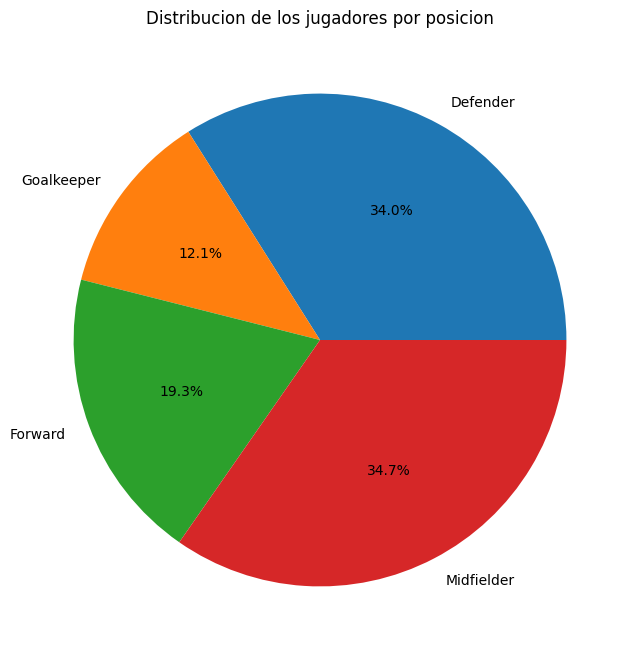

In [ ]:
plt.figure(figsize=(12,8))
plt.pie(data=df_por_posicion.toPandas(),x="count",labels="Position",autopct='%1.1f%%')
plt.title("Distribucion de los jugadores por posicion")
plt.show()

Defensores y mediocampistas dominan el dataset con 34% cada uno, representando casi el 70% del total. Los delanteros ocupan el 19.3%, mientras que los porteros son la minoría con solo 12.1%. Esta distribución refleja la estructura típica de los equipos de fútbol.

***Top 10 jugadores con mas presencias***

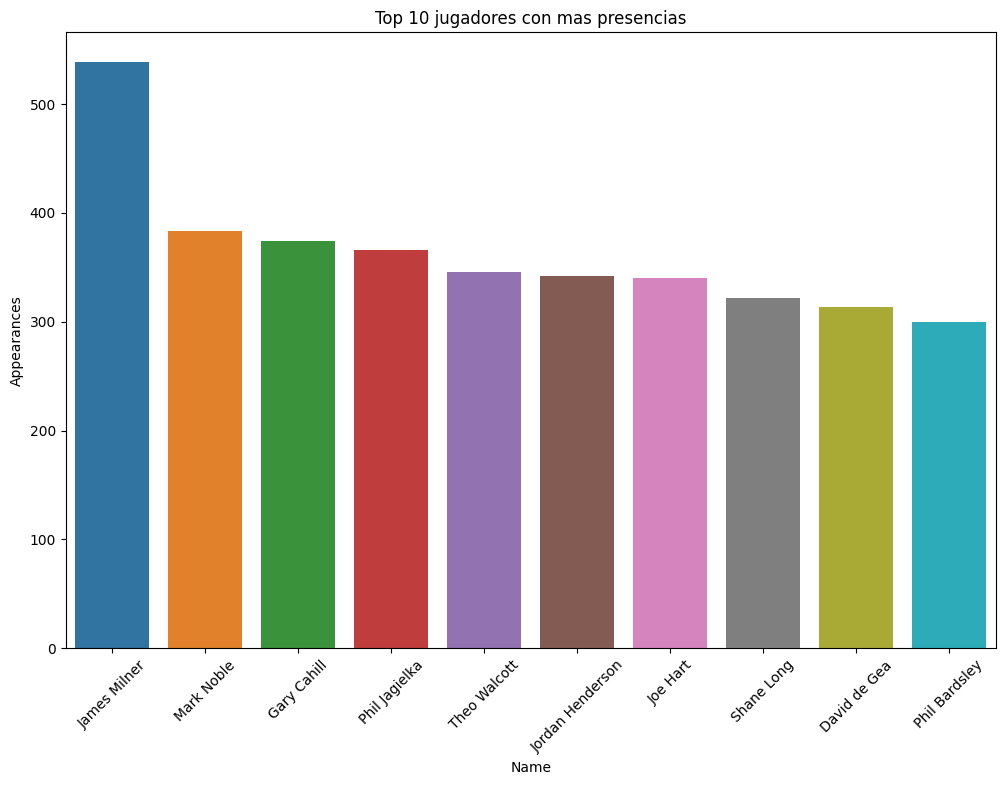

In [ ]:
df_presencias = df.select("Name","Appearances").orderBy("Appearances",ascending=False).limit(10)
plt.figure(figsize=(12,8))
sns.barplot(data=df_presencias.toPandas(),x="Name",y="Appearances",hue="Name")
plt.title("Top 10 jugadores con mas presencias")
plt.xticks(rotation=45)
plt.show()

James Milner lidera con más de 530 apariciones, seguido por Mark Noble  y Gary Cahill. La diferencia notable entre el primero y el resto sugiere una carrera excepcionalmente longeva. Los valores oscilan entre 300-540 apariciones, indicando jugadores con carreras muy establecidas.

***Cantidad de jugadores por pais***

In [ ]:
df_nacionalidad = df.groupBy("Nationality").count().orderBy("count", ascending=False)
df_nacionalidad = df_nacionalidad.withColumn("Nationality",
                                             functions.when(functions.col("Nationality") == "England", "United Kingdom").otherwise(functions.col("Nationality")))

df_nacionalidad_pd = df_nacionalidad.toPandas()

fig = px.choropleth(df_nacionalidad_pd,
                    locations="Nationality",
                    locationmode='country names',
                    color="count",
                    hover_name="Nationality",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="Cantidad de jugadores por país")
fig.show()

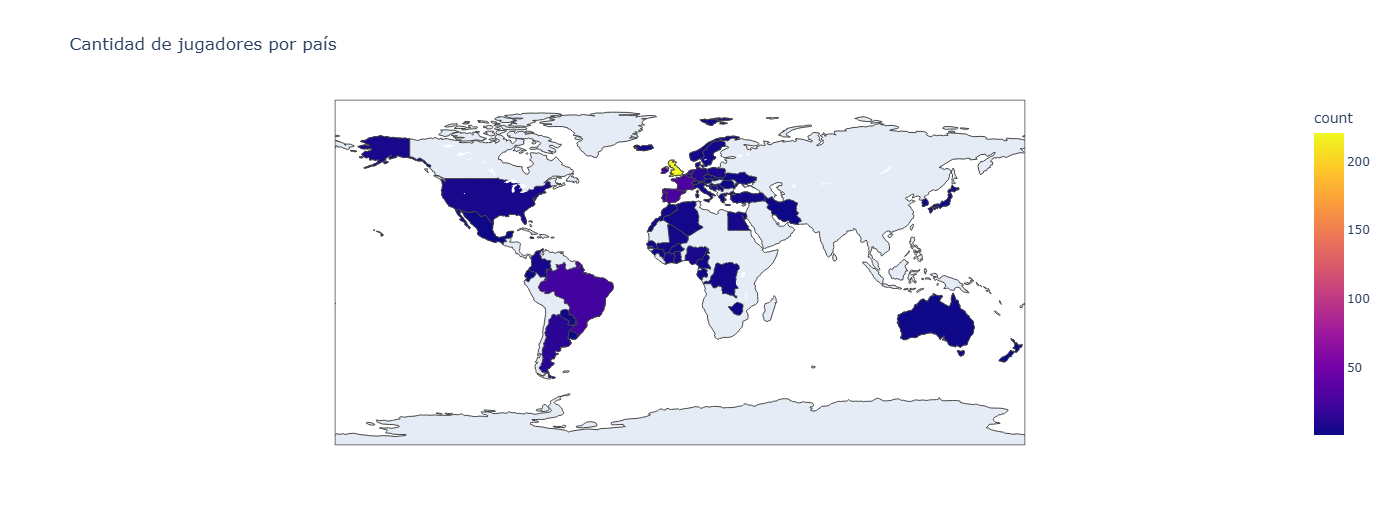

El mapa muestra concentración en Europa Occidental, Norteamérica y partes de Sudamérica. El tono amarillo sugiere mayor representación por parte de Inglaterra, seguida de países como Francia, Alemania, España y Brasil. Refleja la globalización del fútbol europeo.

***Top 5 futbolistas con mas goles y su desglose(pierna derecha,pierna izquierda y de cabeza)***

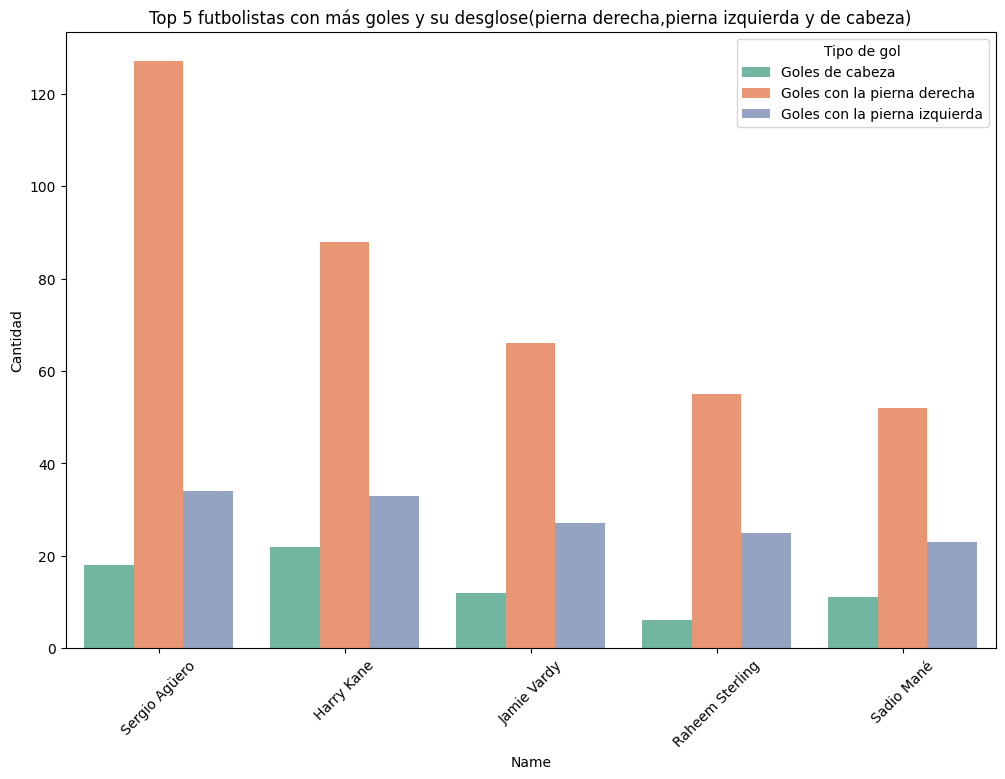

In [ ]:
df_goles = df.select("Name","Goals","Headed goals","Goals with right foot","Goals with left foot").orderBy("Goals",ascending=False).limit(5)
df_goles = df_goles.melt(ids=["Name"], values=["Headed goals", "Goals with right foot", "Goals with left foot"],variableColumnName="Tipo de gol", valueColumnName="Cantidad")
df_goles = df_goles.withColumn(
    "Tipo de gol",
    functions.when(functions.col("Tipo de gol") == "Headed goals", "Goles de cabeza")
     .when(functions.col("Tipo de gol") == "Goals with right foot", "Goles con la pierna derecha")
     .when(functions.col("Tipo de gol") == "Goals with left foot", "Goles con la pierna izquierda")
     .otherwise(functions.col("Tipo de gol"))
)
plt.figure(figsize=(12,8))
sns.barplot(data=df_goles.toPandas(),x="Name",y="Cantidad",hue="Tipo de gol",palette="Set2")
plt.title("Top 5 futbolistas con más goles y su desglose(pierna derecha,pierna izquierda y de cabeza)")
plt.xticks(rotation=45)
plt.show()

Sergio Agüero domina con ~125 goles de pierna derecha y ~35 de izquierda, siendo el más letal. Harry Kane muestra ~88 con derecha y ~34 con izquierda. Los cinco atacantes dependen mayormente de su pierna dominante (derecha), con los goles de cabeza siendo la menor proporción para todos.

***Evaluando la eficiencia goleadora de los delanteros(se tomará los delanteros con más de 10 goles)***

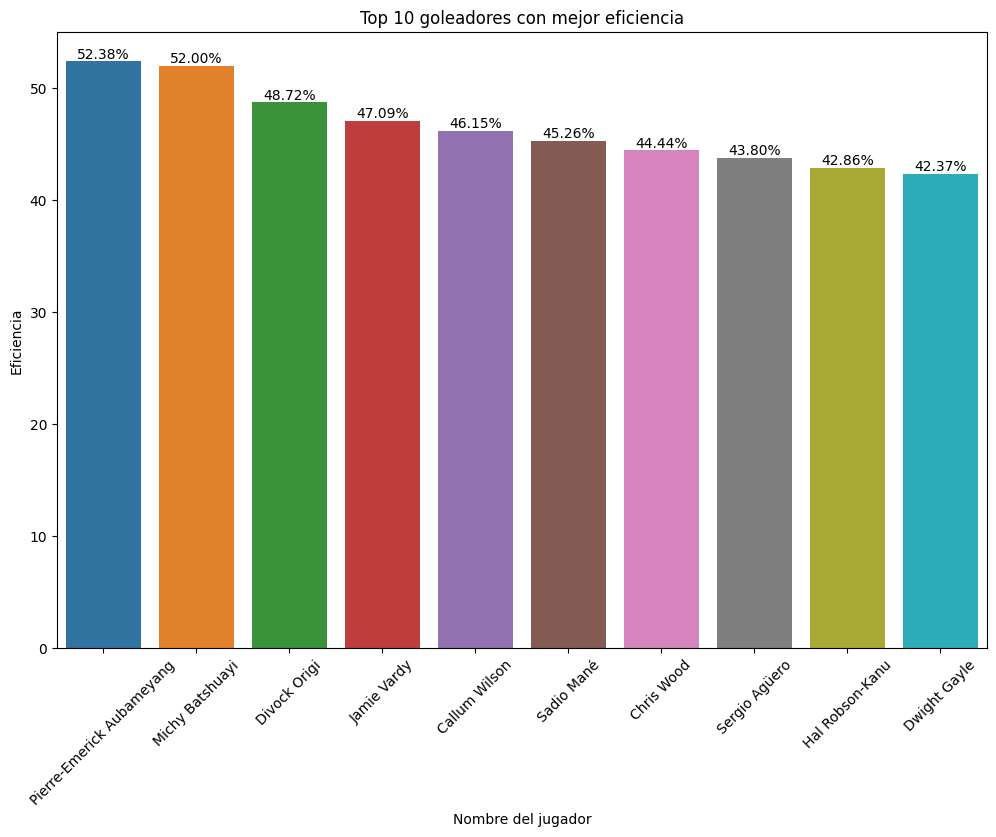

In [ ]:
df_goleadores_eficiencia = df.select("Name","Position","Goals","Shots on target").filter((functions.col("Position") == 'Forward') & (functions.col("Goals").cast("int") > 10))
df_goleadores_eficiencia = df_goleadores_eficiencia.withColumn("Eficiencia",(functions.col("Goals")/functions.col("Shots on target"))*100)
df_goleadores_eficiencia = df_goleadores_eficiencia.orderBy("Eficiencia",ascending=False).limit(10)
plt.figure(figsize=(12,8))
ax = sns.barplot(data=df_goleadores_eficiencia.toPandas(),x="Name",y="Eficiencia",hue="Name",legend=False)
plt.title("Top 10 goleadores con mejor eficiencia")
plt.xticks(rotation=45)
plt.xlabel("Nombre del jugador")
plt.ylabel("Eficiencia")

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%')

plt.show()

Las eficiencias son notablemente altas y compactas (42-52%), con Pierce-Emerick Aubameyang liderando (52.38%) seguido muy de cerca por Michy Batshuayi (52%). La diferencia entre el primero y décimo es de solo ~10 puntos porcentuales, indicando calidad consistente entre los mejores finalizadores.

***Top 10 arqueros con mejor relación porterias a cero/partidos jugados con mas de 10 partidos jugados***

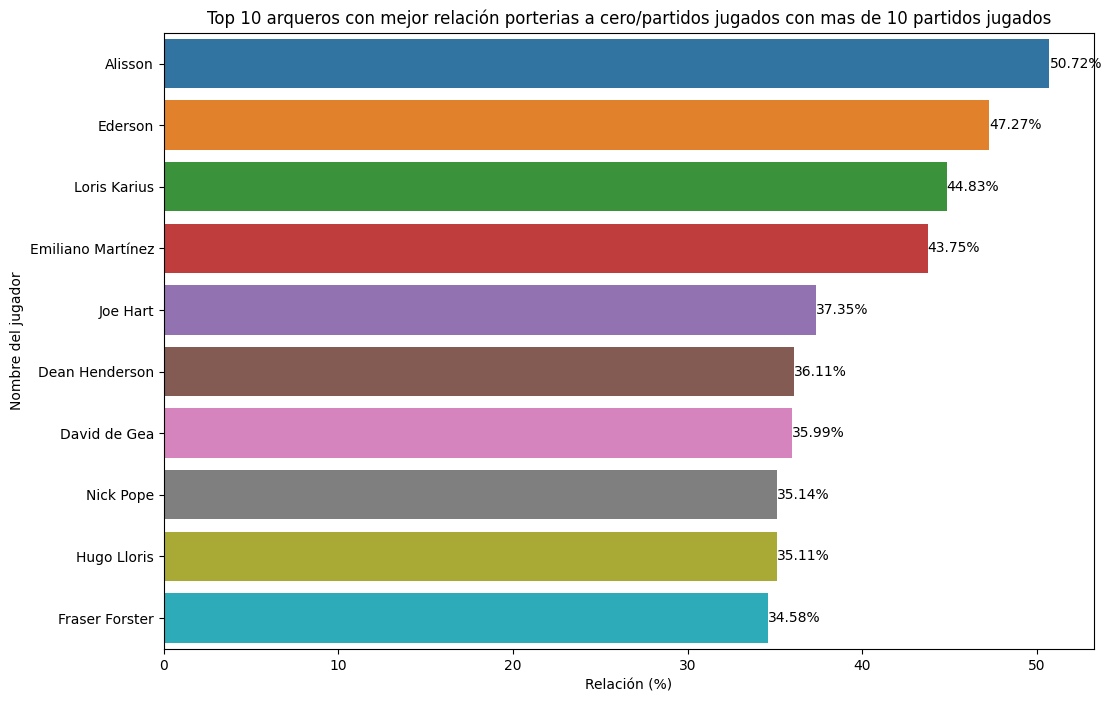

In [ ]:
df_arqueros = df.select("Name","Appearances","Clean sheets","Position").filter((functions.col("Position") == 'Goalkeeper') & (functions.col("Appearances").cast("int") > 10))
df_arqueros = df_arqueros.withColumn("Relacion(%)",(functions.col("Clean sheets")/functions.col("Appearances").cast("int"))*100)
df_arqueros = df_arqueros.orderBy("Relacion(%)",ascending=False).limit(10)
plt.figure(figsize=(12,8))
ax = sns.barplot(data=df_arqueros.toPandas(),y="Name",x="Relacion(%)",hue="Name")
plt.title("Top 10 arqueros con mejor relación porterias a cero/partidos jugados con mas de 10 partidos jugados")
plt.xlabel("Relación (%)")
plt.ylabel("Nombre del jugador")

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%')

plt.show()

Alisson lidera con 50.72%, seguido por Ederson (47.27%). La diferencia del líder al décimo (Fraser Forster con 34.58%) es de ~16 puntos porcentuales, mayor variación que en otras métricas. Refleja tanto calidad individual como fortaleza defensiva de sus equipos.

***Evaluando la eficiencia de los arqueros(Top 10 mejores con minimo 10 partidos jugados)***

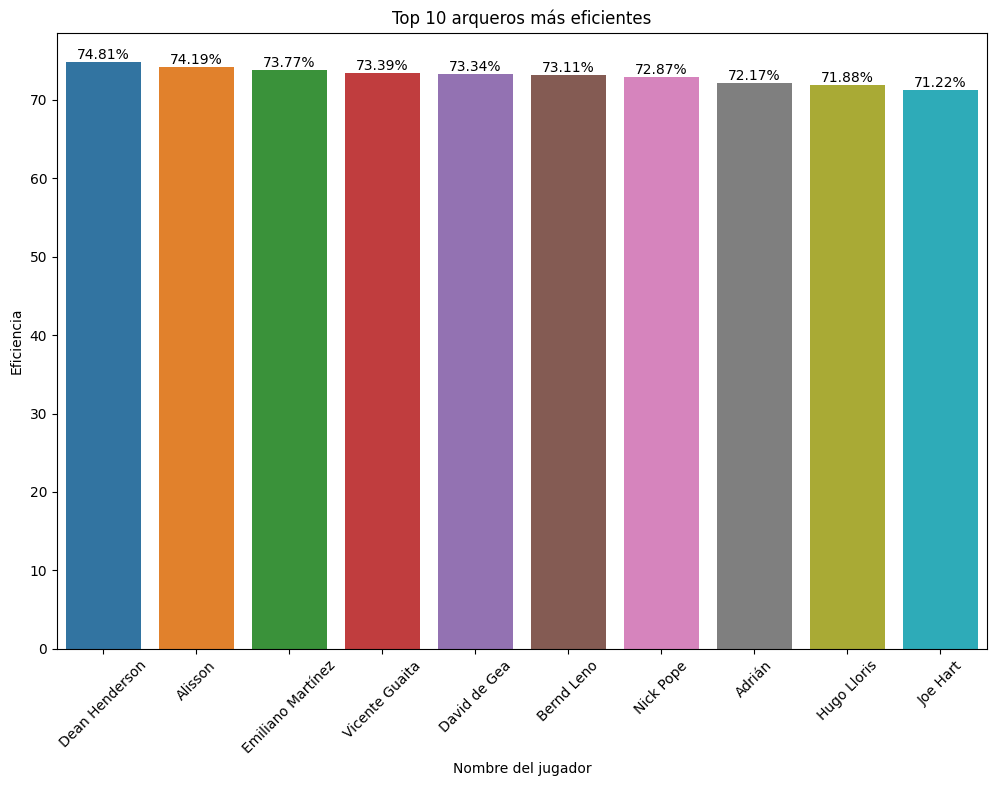

In [ ]:
df_arqueros_eficiencia = df.select("Name","Position","Saves","Penalties saved","Goals conceded","Appearances").filter((functions.col("Position") == 'Goalkeeper') & (functions.col("Appearances").cast("int") > 10))
df_arqueros_eficiencia = df_arqueros_eficiencia.withColumn(
    "Eficiencia",
    ((functions.col("Saves") + functions.col("Penalties saved")) /
     (functions.col("Saves") + functions.col("Penalties saved") + functions.col("Goals conceded"))) * 100
)
df_arqueros_eficiencia = df_arqueros_eficiencia.orderBy("Eficiencia",ascending=False).limit(10)
plt.figure(figsize=(12,8))
ax = sns.barplot(data=df_arqueros_eficiencia.toPandas(),x="Name",y="Eficiencia",hue="Name",legend=False)
plt.title("Top 10 arqueros más eficientes")
plt.xticks(rotation=45)
plt.xlabel("Nombre del jugador")
plt.ylabel("Eficiencia")

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%')

plt.show()


Eficiencias muy altas y compactas (71-75%), con Dean Henderson en la cima (74.81%). La diferencia mínima de ~3.6% entre el primero y décimo sugiere que los mejores porteros mantienen estándares muy similares de rendimiento en cuanto a atajadas

***Jugadores más creativos(medido como la suma de asistencias y grandes oportunidades creativas)***

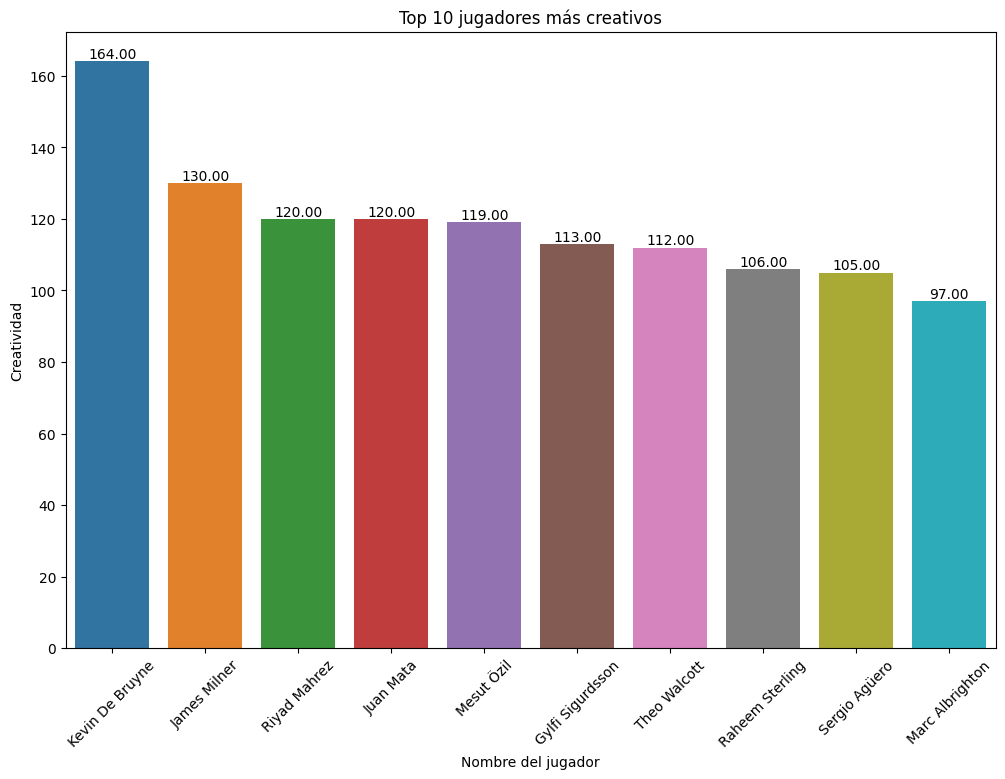

In [ ]:
df_jugadores_creativos = df.select("Name","Assists","Big chances created")
df_jugadores_creativos = df_jugadores_creativos.withColumn("Creatividad",(functions.col("Big chances created") + functions.col("Assists")))
df_jugadores_creativos = df_jugadores_creativos.orderBy("Creatividad",ascending=False).limit(10)

plt.figure(figsize=(12,8))
ax = sns.barplot(data=df_jugadores_creativos.toPandas(),x="Name",y="Creatividad",hue="Name",legend=False)
plt.title("Top 10 jugadores más creativos")
plt.xticks(rotation=45)
plt.xlabel("Nombre del jugador")
plt.ylabel("Creatividad")

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f')

plt.show()

Kevin De Bruyne sobresale con 164 asistencias/acciones creativas, 34 más que el segundo (James Milner, 130). La brecha entre De Bruyne y el resto es significativa, consolidándolo como el creador de juego más prolífico del dataset.

***Analizando si la cantidad de grandes oportunidades creadas tiene que ver con la cantidad de pases***

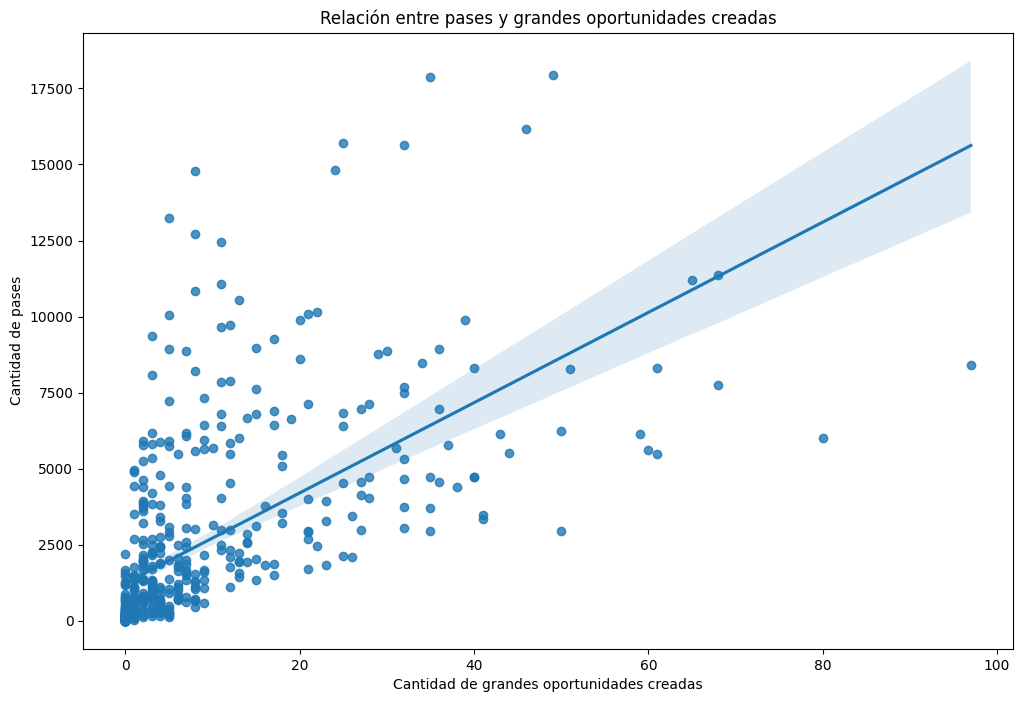

El coeficiente de correlación es: 0.6071216424140974


In [ ]:
df_pases_oportunidades = df.select("Name","Big chances created","Passes")
plt.figure(figsize=(12,8))
sns.regplot(data=df_pases_oportunidades.toPandas(),x="Big chances created",y="Passes")
plt.title("Relación entre pases y grandes oportunidades creadas")
plt.xlabel("Cantidad de grandes oportunidades creadas")
plt.ylabel("Cantidad de pases")
plt.show()
print("El coeficiente de correlación es:",df_pases_oportunidades.stat.corr("Big chances created","Passes"))

Tanto el coeficiente de correlacion como la gráfica muestran que no hay una gran relacion entre la cantidad de chances creadas y la cantidad de pases, esto indica que una mayor cantidad de pases no asegura que sean pases progresivos para generar chanches de gol

***Observando los defensores con mas dominio aéreo***

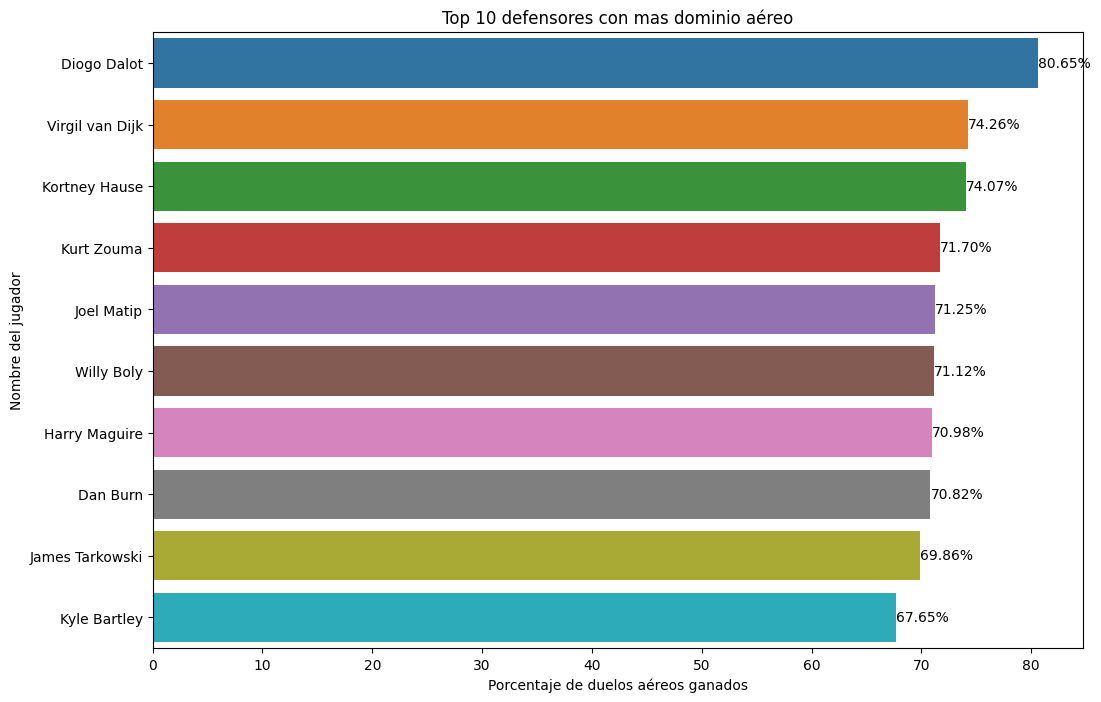

In [ ]:
df_defensores = df.select("Name","Position","Aerial battles won","Aerial battles lost").filter((functions.col("Position") == 'Defender') & (functions.col("Aerial battles won").cast("int") > 1) & (functions.col("Aerial battles lost").cast("int") > 1))
df_defensores = df_defensores.withColumn("Dominio aéreo",(functions.col("Aerial battles won")/(functions.col("Aerial battles won") +functions.col("Aerial battles lost")))*100)
df_defensores = df_defensores.orderBy("Dominio aéreo",ascending=False).limit(10)

plt.figure(figsize=(12,8))
ax = sns.barplot(data=df_defensores.toPandas(),y="Name",x="Dominio aéreo",hue="Name",legend=False)
plt.title("Top 10 defensores con mas dominio aéreo")
plt.xlabel("Porcentaje de duelos aéreos ganados")
plt.ylabel("Nombre del jugador")

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f%%')

plt.show()

Diogo Dalot lidera con 80.65% de duelos aéreos ganados, seguido por Virgil van Dijk (74.26%). Los porcentajes van del 67% al 80%, mostrando diferencias más pronunciadas que en otras métricas defensivas. Refleja especialización en juego aéreo.

***Analizando si las participaciones defensivas tienen relación con la cantidad de goles concedidos***

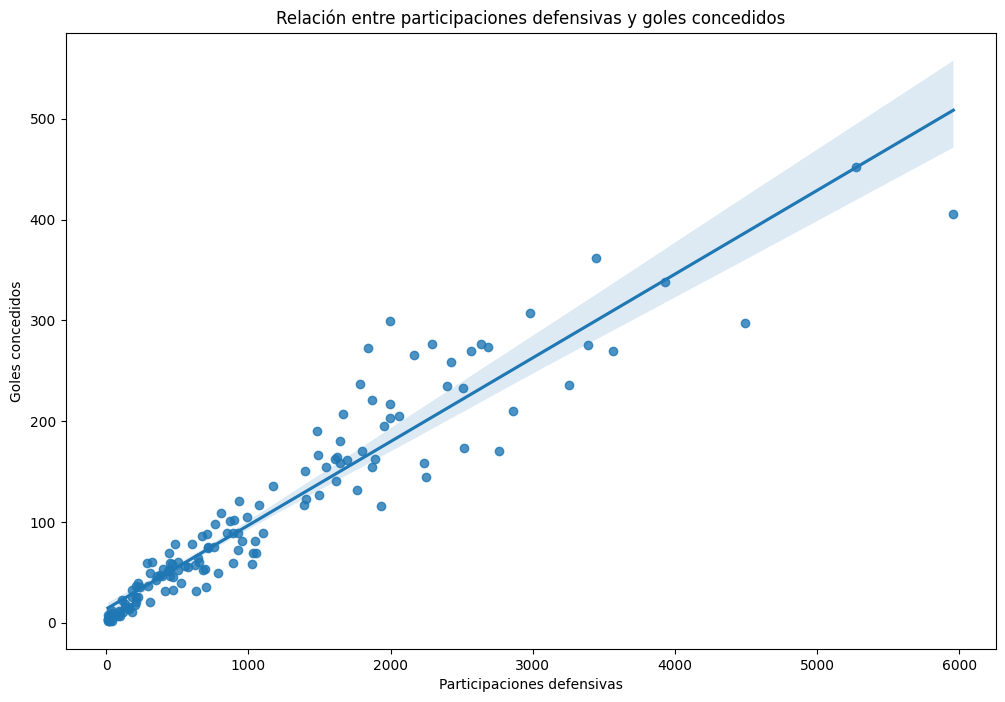

In [ ]:
df_defensores_efectivos = df.select("Name","Position","Goals conceded","Tackles","Interceptions","Blocked shots","Recoveries","Clearances").filter((functions.col("Position") == 'Defender') & (functions.col("Goals conceded").cast("int") > 1))
df_defensores_efectivos = df_defensores_efectivos.withColumn("Participaciones defensivas",(functions.col("Tackles") + functions.col("Interceptions") + functions.col("Blocked shots") + functions.col("Recoveries") + functions.col("Clearances")))

plt.figure(figsize=(12,8))
sns.regplot(data=df_defensores_efectivos.toPandas(),x="Participaciones defensivas",y="Goals conceded")
plt.title("Relación entre participaciones defensivas y goles concedidos")
plt.xlabel("Participaciones defensivas")
plt.ylabel("Goles concedidos")
plt.show()



Existe una correlación positiva clara: más participaciones defensivas se asocian con más goles concedidos. Esto sugiere que equipos que defienden más (bajo mayor presión) tienden a conceder más goles, reflejando dominio territorial del rival

***Matriz de correlación***

<Axes: >

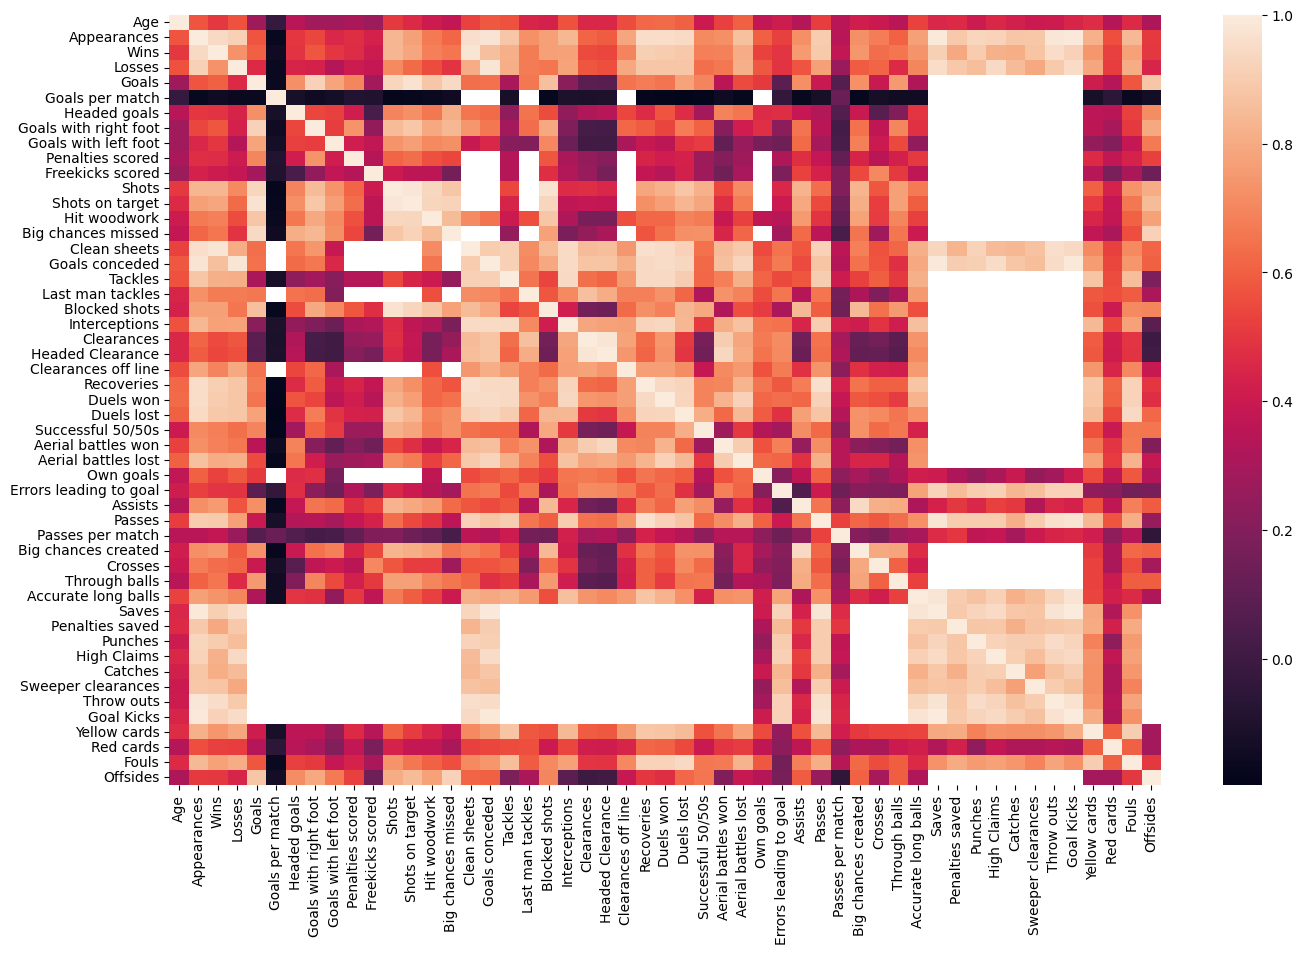

In [ ]:
df_pandas = df.toPandas()
df_pandas = df_pandas.drop("Jersey Number",axis=1)
matriz_corr = df_pandas.corr(numeric_only=True)
plt.figure(figsize=(16,10))
sns.heatmap(matriz_corr)


***Caracteristicas con más de 0.9 de coeficiente de correlacion***

<Axes: >

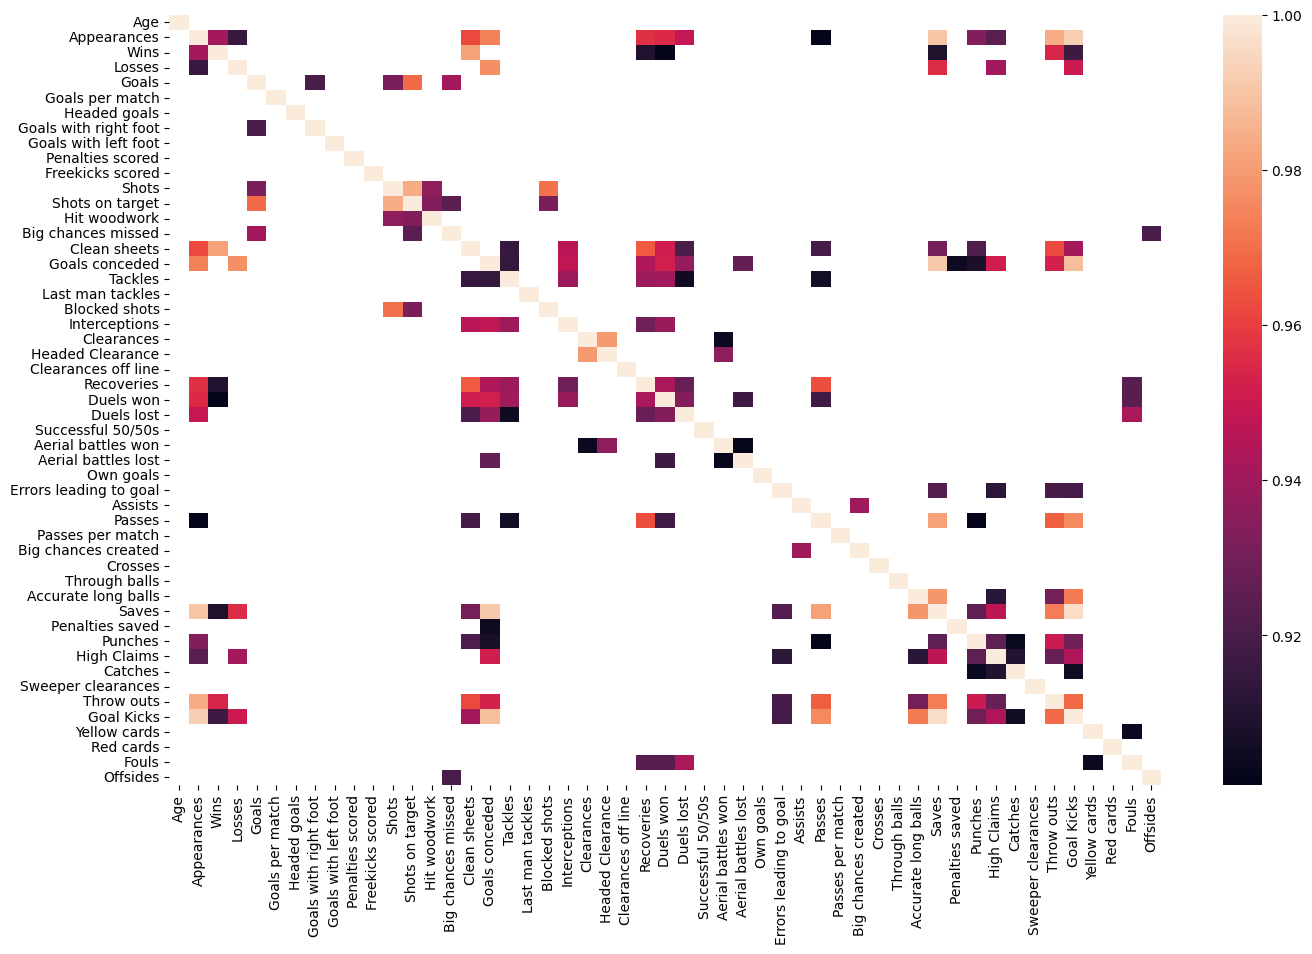

In [ ]:
matriz_corr_filtrada = matriz_corr[abs(matriz_corr) >= 0.9]
plt.figure(figsize=(16,10))
sns.heatmap(matriz_corr_filtrada)

Se hará una prediccion para la cantidad de porterias a cero(Clean sheets) usando regresion polinomica y Ridge

In [ ]:
corr_porterias_a_cero = matriz_corr_filtrada['Clean sheets']
corr_porterias_a_cero_filtradas = corr_porterias_a_cero[corr_porterias_a_cero >= 0.9]
corr_porterias_a_cero_filtradas = corr_porterias_a_cero_filtradas.drop('Clean sheets')

In [ ]:
caracteristicas_filtradas = corr_porterias_a_cero_filtradas.index.tolist()

Antes de proceder a hacer algun tipo de regresion, se llenarán los valores nulos con la media de la respectiva columna

In [ ]:
x = df_pandas[caracteristicas_filtradas]
x = x.fillna(x.mean())
y = df_pandas["Clean sheets"]
y = y.fillna(y.mean())


In [ ]:
def regresion_polinomica_min_max(grado):
    """
    Entrena un modelo de regresión polinómica con normalizacion min-max:

    Parámetros:
        df : DataFrame
        grado : int, grado del polinomio

    """
    # === 1. Dividir los datos ===

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # === 2. Crear polinomio ===
    poly = PolynomialFeatures(degree=grado, include_bias=False)

    # === 3. Normalización Min-Max ===
    scaler_minmax = MinMaxScaler()
    x_train_escalado = scaler_minmax.fit_transform(x_train)
    x_test_escalado = scaler_minmax.transform(x_test)

    x_train_poly = poly.fit_transform(x_train_escalado)
    x_test_poly = poly.transform(x_test_escalado)

    model_minmax = LinearRegression()
    model_minmax.fit(x_train_poly, y_train)

    r2_train_minmax  = model_minmax .score(x_train_poly, y_train)
    rmse_train_minmax  = np.sqrt(mean_squared_error(y_train, model_minmax.predict(x_train_poly)))

    y_pred_minmax = model_minmax.predict(x_test_poly)

    r2_test_minmax = r2_score(y_test, y_pred_minmax)
    rmse_test_minmax = np.sqrt(mean_squared_error(y_test, y_pred_minmax))

    return r2_test_minmax, rmse_test_minmax,r2_train_minmax,rmse_train_minmax

In [ ]:
def regresion_polinomica_std(grado):
    """
    Entrena un modelo de regresión polinómica con normalizacion estandar:

    Parámetros:
        df : DataFrame
        grado : int, grado del polinomio

    """
    # === 1. Dividir los datos ===

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

    # === 2. Crear polinomio ===
    poly = PolynomialFeatures(degree=grado, include_bias=False)

    # === 3. Normalización Min-Max ===
    scaler_std = StandardScaler()
    x_train_escalado = scaler_std.fit_transform(x_train)
    x_test_escalado = scaler_std.transform(x_test)

    x_train_poly = poly.fit_transform(x_train_escalado)
    x_test_poly = poly.transform(x_test_escalado)

    model_std = LinearRegression()
    model_std.fit(x_train_poly, y_train)

    y_pred_std = model_std.predict(x_test_poly)

    r2_train_std = model_std.score(x_train_poly, y_train)
    rmse_train_std = np.sqrt(mean_squared_error(y_train, model_std.predict(x_train_poly)))

    r2_test_std = r2_score(y_test, y_pred_std)
    rmse_test_std = np.sqrt(mean_squared_error(y_test, y_pred_std))

    return r2_test_std, rmse_test_std,r2_train_std,rmse_train_std

In [ ]:
def regresion_ridge_min_max(grado):
    """
    Entrena un modelo de regresión Ridge con búsqueda de hiperparámetros (GridSearchCV)
    usando normalización Min-Max.

    """
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42 )

    poly = PolynomialFeatures(degree=grado, include_bias=False)
    x_train_poly = poly.fit_transform(x_train)
    x_test_poly = poly.transform(x_test)


    scaler = MinMaxScaler()
    x_train_scaled = scaler.fit_transform(x_train_poly)
    x_test_scaled = scaler.transform(x_test_poly)


    ridge = Ridge()

    #grilla de búsqueda
    grid = {"alpha": np.logspace(-4, 4, 20)}


    grid_search = GridSearchCV(
        ridge,
        grid,
        cv=5,
        scoring="r2",
        n_jobs=-1,
    )
    grid_search.fit(x_train_scaled, y_train)

    # Mejor modelo ===
    mejor_modelo = grid_search.best_estimator_
    mejor_alpha = grid_search.best_params_["alpha"]
    mejor_score_train = grid_search.best_score_
    rmse_train = np.sqrt(mean_squared_error(y_train, mejor_modelo.predict(x_train_scaled)))

    # Test ===
    y_pred = mejor_modelo.predict(x_test_scaled)
    r2_test = r2_score(y_test, y_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

    return mejor_alpha, mejor_score_train, r2_test, rmse_test,rmse_train


In [ ]:
def regresion_ridge_std(grado):
    """
    Entrena un modelo de regresión Ridge con búsqueda de hiperparámetros (GridSearchCV)
    usando normalización Min-Max.

    """
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42 )

    poly = PolynomialFeatures(degree=grado, include_bias=False)
    x_train_poly = poly.fit_transform(x_train)
    x_test_poly = poly.transform(x_test)


    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_poly)
    x_test_scaled = scaler.transform(x_test_poly)


    ridge = Ridge()

    #grilla de búsqueda
    grid = {"alpha": np.logspace(-4, 4, 20)}


    grid_search = GridSearchCV(
        ridge,
        grid,
        cv=5,
        scoring="r2",
        n_jobs=-1,
    )
    grid_search.fit(x_train_scaled, y_train)

    # Mejor modelo ===
    mejor_modelo = grid_search.best_estimator_
    mejor_alpha = grid_search.best_params_["alpha"]
    mejor_score_train = grid_search.best_score_
    rmse_train = np.sqrt(mean_squared_error(y_train, mejor_modelo.predict(x_train_scaled)))

    # Test ===
    y_pred = mejor_modelo.predict(x_test_scaled)
    r2_test = r2_score(y_test, y_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))

    return mejor_alpha, mejor_score_train, r2_test, rmse_test,rmse_train


In [ ]:
#Regresion polinómica
r2_test_minmax, rmse_test_minmax,r2_train_minmax,rmse_train_minmax = regresion_polinomica_min_max(grado = 1)
r2_test_std, rmse_test_std,r2_train_std,rmse_train_std = regresion_polinomica_std(grado = 1)
#Regresión polinómica Ridge
alpha_ridge_minmax, r2_train_ridge_minmax, r2_test_ridge_minmax, rmse_test_ridge_minmax,rmse_train_ridge_minmax = regresion_ridge_min_max(grado=2)
alpha_ridge_std, r2_train_ridge_std, r2_test_ridge_std,rmse_test_ridge_std, rmse_train_ridge_std = regresion_ridge_std(grado=2)

resultados = {
    "Normalización": ["Min-Max", "Estandar", "Min-Max", "Estandar"],
    "Modelo": ["Ridge", "Ridge", "Sin Ridge", "Sin Ridge"],
    "R2 test": [r2_test_ridge_minmax, r2_test_ridge_std, r2_test_minmax, r2_test_std],
    "R2 train": [r2_train_ridge_minmax, r2_train_ridge_std, r2_train_minmax, r2_train_std],
    "RMSE test": [rmse_test_ridge_minmax, rmse_test_ridge_std, rmse_test_minmax, rmse_test_std],
    "RMSE train": [rmse_train_ridge_minmax, rmse_train_ridge_std, rmse_train_minmax, rmse_train_std]
}
df_resultados = pd.DataFrame(resultados)

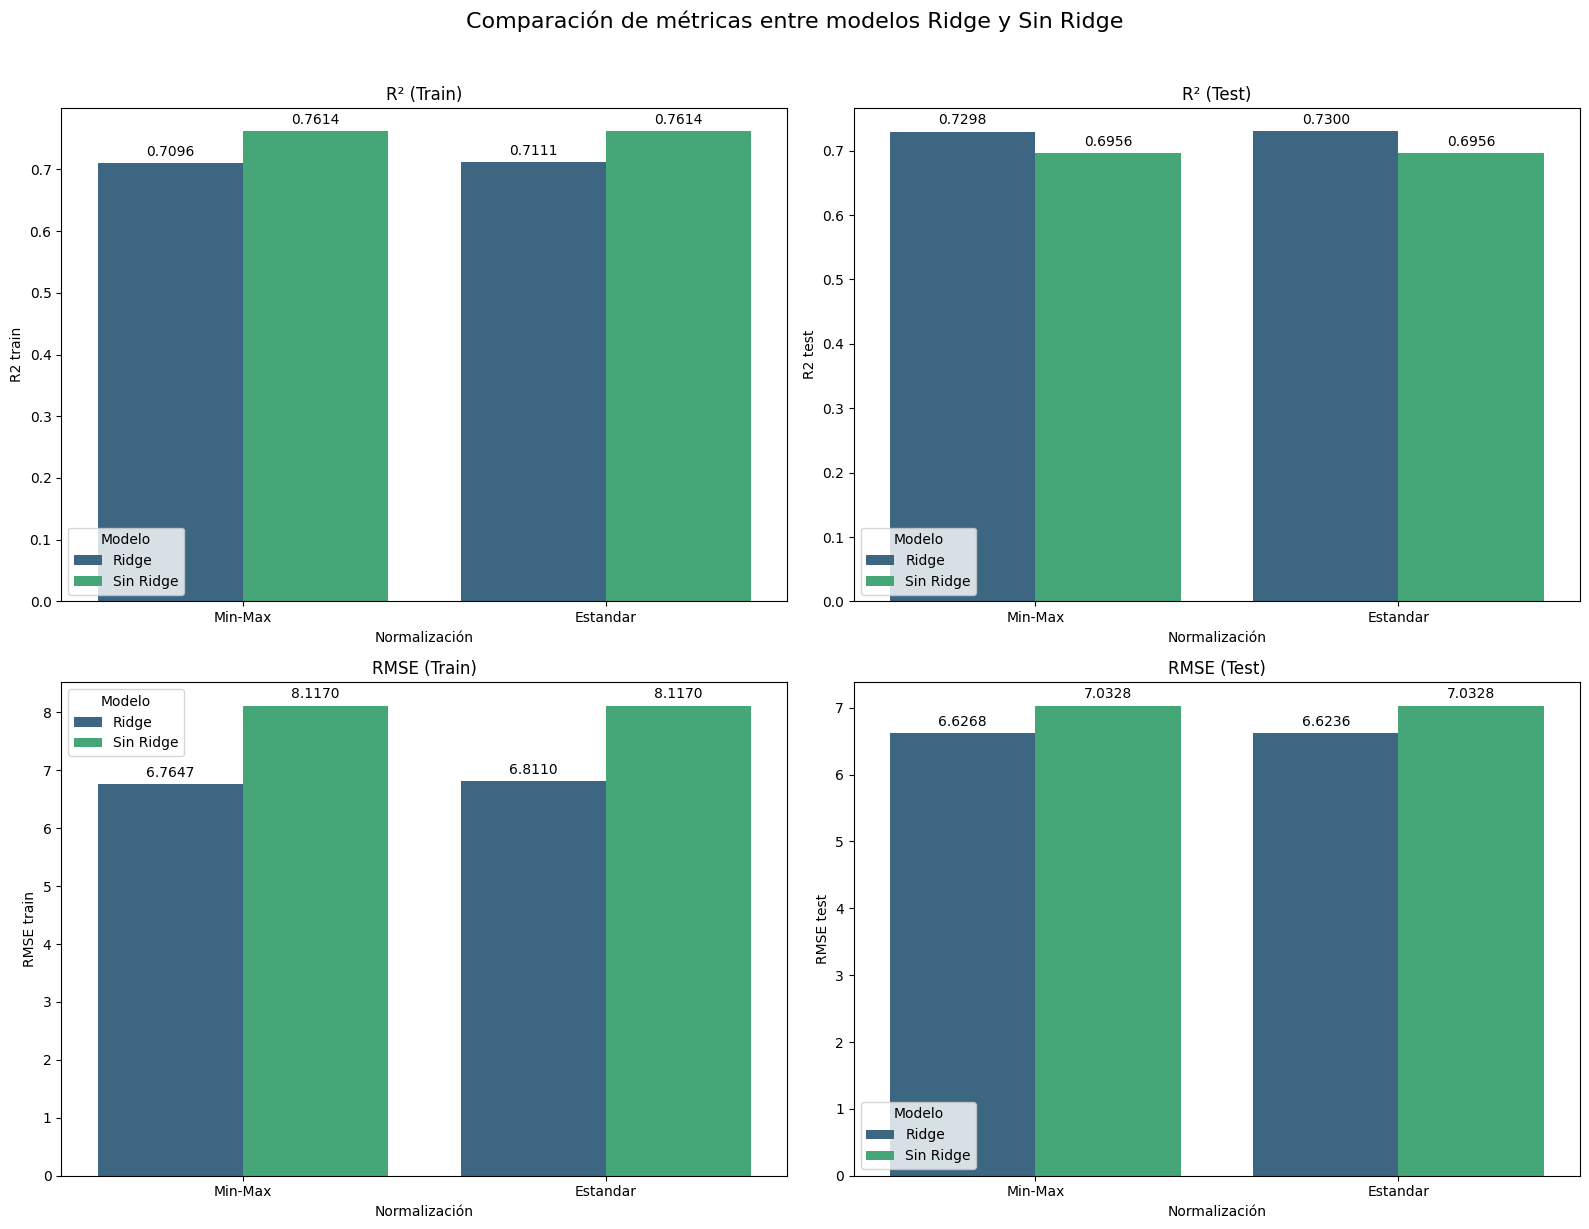

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Comparación de métricas entre modelos Ridge y Sin Ridge", fontsize=16, y=1.02)

metricas = ["R2 train", "R2 test", "RMSE train", "RMSE test"]
titulos = ["R² (Train)", "R² (Test)", "RMSE (Train)", "RMSE (Test)"]

for ax, metrica, titulo in zip(axes.flat, metricas, titulos):
    sns.barplot(data=df_resultados, x="Normalización", y=metrica, hue="Modelo", ax=ax, palette="viridis")
    ax.set_title(titulo)
    ax.set_xlabel("Normalización")
    ax.set_ylabel(metrica)
    for container in ax.containers:
        ax.bar_label(container, fmt='%.4f', label_type='edge', padding=3)
    ax.legend(title="Modelo")

plt.tight_layout()
plt.show()

***R² (Train/Test):***

* Los valores de R2 están entre 0.69 y 0.76, lo que indica un buen nivel de ajuste, aunque no perfecto.

* El modelo Ridge logra un ligero mejor rendimiento en entrenamiento, pero en test la diferencia con el modelo sin regularización es mínima.

* Esto sugiere que Ridge ayuda a estabilizar el modelo (reduce el sobreajuste), pero en este caso los datos no eran altamente colineales ni ruidosos, por lo que la mejora no es grande.

***RMSE (Train/Test):***

* Los errores (RMSE) se mantienen entre 6.6 y 8.1, lo cual es coherente con los valores de R².

* Nuevamente, Ridge obtiene un error ligeramente menor en entrenamiento, pero las diferencias son pequeñas en test, confirmando que ambos modelos generalizan de forma similar.

***Normalización (Min-Max vs Estandar):***

* No hay una diferencia significativa entre ambas escalas.

* Esto indica que los datos tienen una distribución ya relativamente homogénea, por lo que el tipo de normalización no afecta sustancialmente el desempeño.